<a href="https://colab.research.google.com/github/bramyeon/korea-happiness-ext/blob/main/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Korea Happiness Extended:</b> SHAP Analysis
Summer Institute in Computational Social Science (SICSS-Korea) 2024 Team Project Extension  

<b>Author:</b> Bryan Nathanael Wijaya ([bryannwijaya@kaist.ac.kr](mailto:bryannwijaya@kaist.ac.kr))  
<b>Team Members (ABC order):</b> Ju Hee Jeung, Kyungmin Lee, Yumi Park

### If you find anything suspicious or wrong, do not hesitate to let me know via [email](mailto:bryannwijaya@kaist.ac.kr). Happy coding!


In [ ]:
#@title Setting up prerequisites and uploading model weights

!pip install deep-translator
!git clone https://github.com/bramyeon/korea-happiness-ext.git
print()

from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy import stats
import shap
from deep_translator import GoogleTranslator

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")
model_type = "korea-complex (141 features)" #@param ['korea-complex (141 features)']
LUCKY_NUMBER = 42

model_type = model_type.split()[0]

num_layers_dict = {
    'korea-complex': 4,
}

data_name = model_type
num_layers = num_layers_dict[data_name]
epochs = 200

print(f"\nModel was trained on the `{data_name}` dataset,\nwith {num_layers} layers and {epochs} epochs.")

class Regressor(nn.Module):
    def __init__(self, features):
        super(Regressor, self).__init__()


        self.layers = []
        for i in range(len(features)-1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(features[-1], 1))

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

class Model:
    def __init__(self, features, lr, beta1, beta2, epochs):
        self.features = features
        self.model = Regressor(self.features)
        self.model = self.model.to(device)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epochs = epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        self.train_loss_epoch = None
        self.test_err_epoch = None

    def update(self, train_loss_epoch, test_err_epoch):
        self.train_loss_epoch = train_loss_epoch
        self.test_err_epoch = test_err_epoch

all_in_dict = {
    'korea-complex': 142,
}

all_in = all_in_dict[model_type]

lr = 1e-3
beta1, beta2 = 0.9, 0.999

models = {
  4: Model([all_in, LUCKY_NUMBER, LUCKY_NUMBER*2, LUCKY_NUMBER], lr, beta1, beta2, epochs),
}

model = models[num_layers]
checkpoint = torch.load(f"korea-happiness-ext/checkpoints/{data_name}-{num_layers}-{epochs}.pth")#(filename)
model.model.load_state_dict(checkpoint)
model.model.to(device)
model.model.eval()

Cloning into 'korea-happiness-ext'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 134 (delta 57), reused 42 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 25.50 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (57/57), done.

Device: cuda

Model was trained on the `korea-complex` dataset,
with 4 layers and 200 epochs.


Regressor(
  (model): Sequential(
    (0): Linear(in_features=142, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=42, bias=True)
    (5): ReLU()
    (6): Linear(in_features=42, out_features=1, bias=True)
  )
)

In [ ]:
#@title Loading test data and initialize SHAP explainer

from tqdm import tqdm

test_data = f"korea-happiness-ext/test-data/{data_name}-test.csv"
df_test = pd.read_csv(test_data)
df_test['bias'] = -1.
del df_test['happiness_ladder']

features_dict = dict()
for i, col in enumerate(df_test.columns):
    features_dict[col] = i

codes = pd.read_excel(f'korea-happiness-ext/code-stats.xlsx')
translator = GoogleTranslator(source='ko', target='en')

transform = {'bias': 'Bias',
             'SO2': 'SO2 level',
             'CO': 'CO level',
             'Ozone': 'Ozone level',
             'NO2': 'NO2 level',
             'PM10': 'PM10 level',
             'PM2.5': 'PM2.5 level',
             'trainee': 'Number of trainees',
             'grdpno': 'GRDP',
             'land': 'Property price fluctuation rate',
             'empl': 'Employment count',
             'jobopen': 'Effective job openings',
             'edu': 'Education level'
}

for i in tqdm(range(len(codes))):
    code = codes['code'][i]
    maindes = codes['description-main'][i]
    supdes = codes['description-sup'][i]

    if pd.isna(supdes):
        if pd.isna(maindes):
            continue
        else:
            transform[code] = GoogleTranslator(source='ko', target='en').translate(maindes)
    else:
        transform[code] = GoogleTranslator(source='ko', target='en').translate(f"{maindes} ({supdes})")

df_test.rename(columns=transform, inplace=True)
df_test.head()
print("Test data scenarios are successfully loaded.")

def predict_fn(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_pred = model.model(x_tensor).cpu().numpy().flatten()
    return y_pred

X_test_df = df_test.copy().reset_index(drop=True)
background = X_test_df.sample(200, random_state=42)
explainer = shap.KernelExplainer(predict_fn, background)

100%|██████████| 311/311 [04:04<00:00,  1.27it/s]


Test data scenarios are successfully loaded.


In [ ]:
#@title Execute SHAP analysis

sample_nums = range(len(df_test))
X_explain = X_test_df.iloc[sample_nums].copy()
shap_values = explainer.shap_values(X_explain, nsamples=200)  # nsamples controls approximation accuracy/speed

  0%|          | 0/3118 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


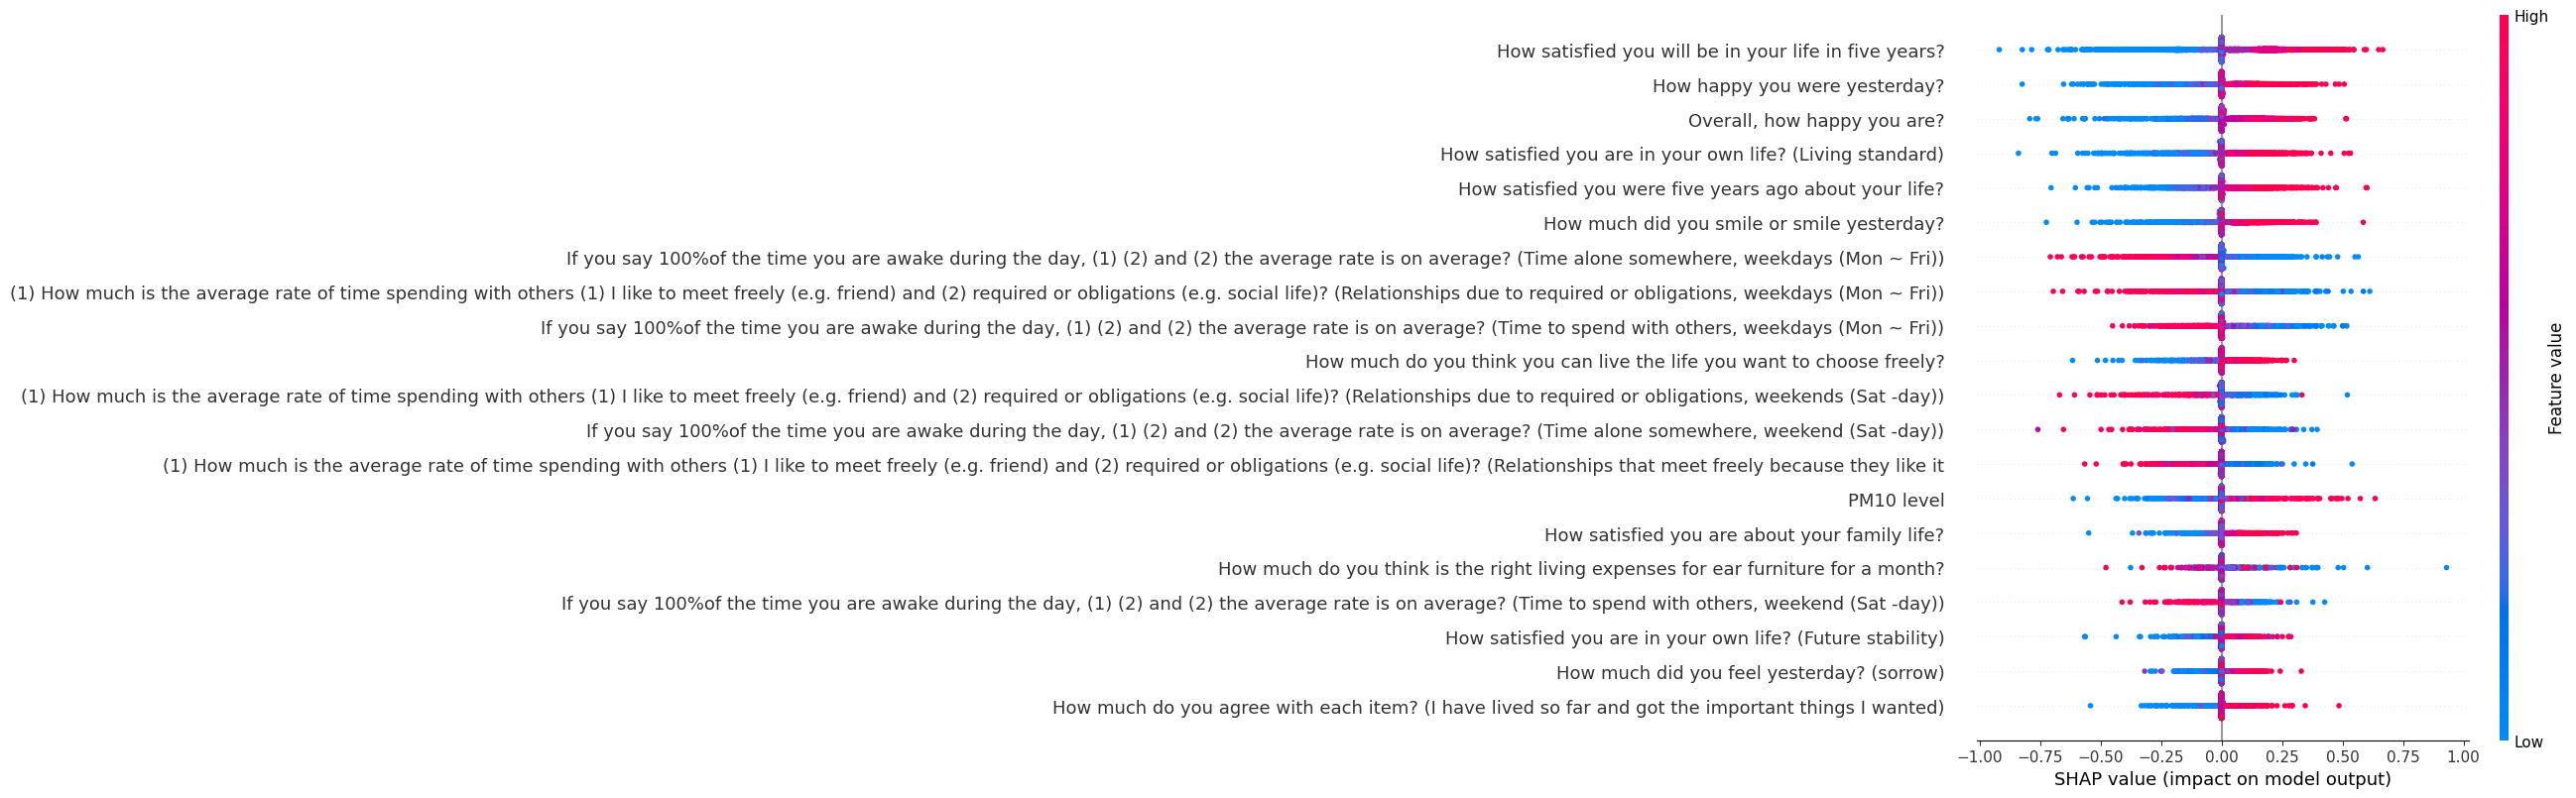

In [ ]:
shap.summary_plot(shap_values, X_explain)

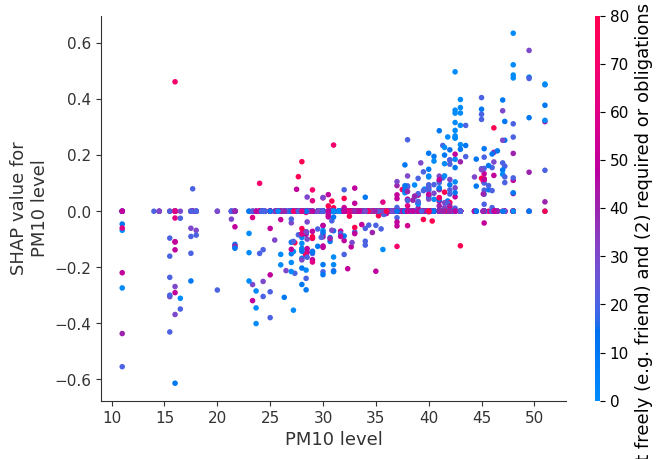

In [ ]:
shap.dependence_plot("PM10 level", shap_values, X_explain)

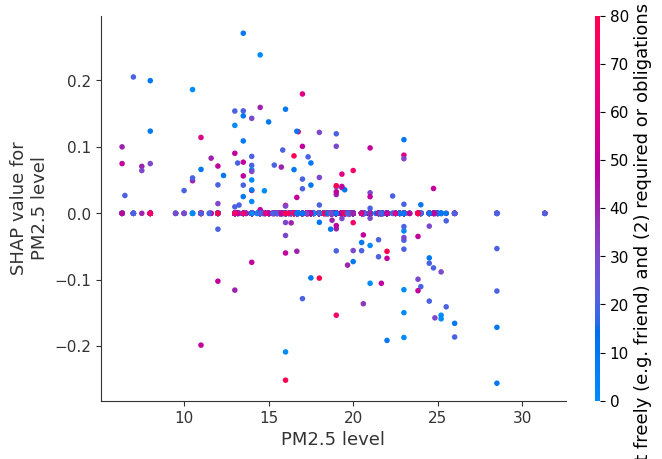

In [ ]:
shap.dependence_plot("PM2.5 level", shap_values, X_explain)

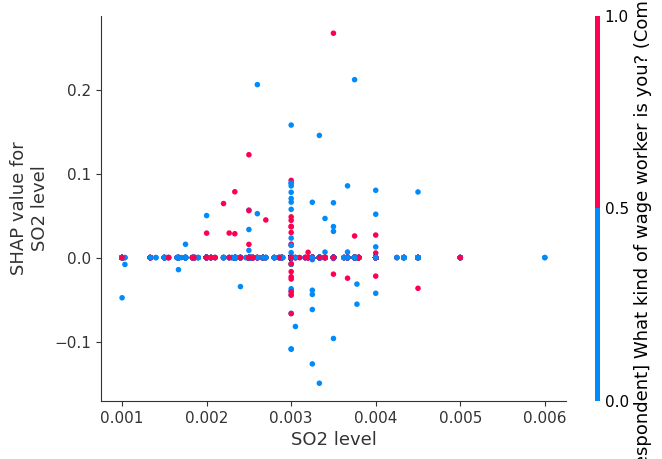

In [ ]:
shap.dependence_plot("SO2 level", shap_values, X_explain)

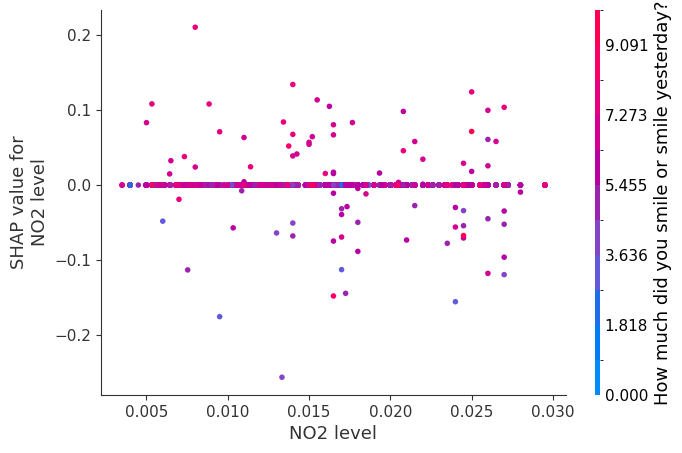

In [ ]:
shap.dependence_plot("NO2 level", shap_values, X_explain)

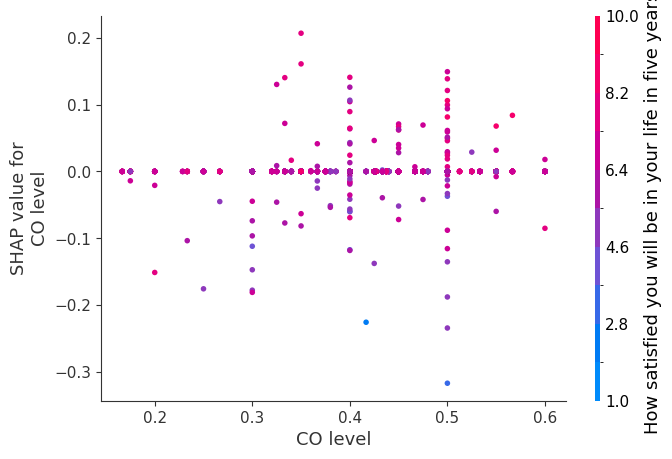

In [ ]:
shap.dependence_plot("CO level", shap_values, X_explain)

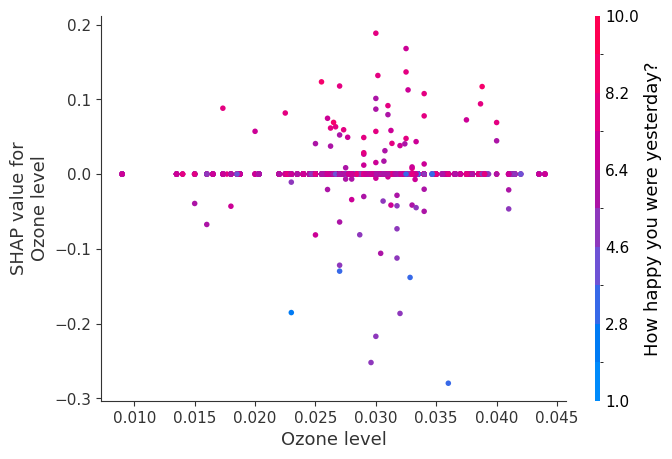

In [ ]:
shap.dependence_plot("Ozone level", shap_values, X_explain)